# Project: Implement Decision Tree Classifier from Scratch

# Getting Started

## Task 1: Prepare the Environment

In [91]:
import numpy as np
import  pandas as pd
from pprint import pprint
from numpy import log2
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix


In [92]:
df = pd.read_csv('/usercode/heart.csv')

In [93]:
eps = np.finfo(float).eps
target = df.keys()[-1]

# The Decision Tree ID 3 Algorithm

## Task 2: Calculate the Entropy of a Feature

In [94]:
def entropy_of_feature(df,feature):
    targets = df[target].unique()
    classes  = df[feature].unique()
    entropy2 = 0
    for feature_class in classes:
        entropy = 0
        for target_class in targets:
            num = len(df[feature][df[feature] == feature_class][df[target]==target_class])
            den = len(df[feature][df[feature] == feature_class])
            fraction = num/(den+eps)
            entropy += -fraction*log2(fraction+eps)
            fraction2 = den/len(df)
            entropy2 += fraction2*entropy

    return entropy2


## Task 3: Select the Best Feature

In [95]:
def best_feature(_df):
    IG = []
    features = list(set(_df.keys())- set([target]))
    for key in features:
        IG.append(1-entropy_of_feature(_df,key))
    result = features[np.argmax(IG)]
    return result

## Task 4: Retrieve the Sub-table

In [96]:
def get_subtable(_data,node,value):
    data = _data.copy()
    data = data[data[node] == value][list(set(data.columns)-set([node]))]
    return data.reset_index(drop=True)

## Task 5: Build the Decision Tree

In [97]:
def build_tree(_df,tree=None):

    node = best_feature(_df)

    nodeClasses = np.unique(_df[node])

    if tree is None:
        tree={}
        tree[node] = {}

    for nodeClass in nodeClasses:

        subtable = get_subtable(_df.copy(),node,nodeClass)
        clValue,counts = np.unique(subtable[target],return_counts=True)

        if len(counts)==1:
            return clValue[0]
        elif len(subtable)==0:
            return 1
        elif len(subtable.keys())==1:
            return 1
        else:
            tree[node][nodeClass] = build_tree(subtable)

    return tree
    

## Task 6: Generate Predictions

In [98]:
def predict(tree,df):
    results = []
    for _, row in df.iterrows():
        res = classify(tree.copy(),row)
        results.append(res)
    return results

In [99]:
def classify(tree,row):
    feat = list(tree.keys())[0]
    if isinstance(tree[feat][row[feat]],dict):
        if row[feat] in tree[feat].keys():
            return classify(tree[feat][row[feat]].copy(),row)
        else:
            print('Unknown feature '+str(row[feat])+' in '+str(tree[feat].keys()))
    else:
        return tree[feat][row[feat]]

# Preprocess the Data

## Task 7: Compute Information Gain of a Feature

In [100]:
def find_gain(df,threshold,attr):
    idx = df[df[attr] <= threshold].index
    tmp_df = df.copy()
    tmp_df[attr] = '>'+str(threshold)
    tmp_df.loc[idx,attr] = '<='+str(threshold)

    return 1-entropy_of_feature(tmp_df,attr)

## Task 8: Convert Continuous Feature to Binary

In [101]:
def cont_2_binary(df, cont=None):
    df = df.copy()
    thresholds = {}
    cont_cols = cont if cont else df._get_numeric_data().columns[:-1]
    for col in cont_cols:
        IG = []
        unique = sorted(df[col].unique())

        for uni in unique:
            IG.append(find_gain(df,uni,col))
        thresholds[col] = unique[np.argmax(IG)]
        idx = df[df[col] <= thresholds[col]].index

        df[col] = '>'+str(thresholds[col])

        df.loc[idx,col] = '<='+str(thresholds[col])
    
    return df

## Task 9: Preprocess the Data

In [102]:
df = cont_2_binary(df)
df_train, df_test = train_test_split(df.sample(frac=1, random_state=1337).reset_index(drop=True), random_state=42, test_size=0.3)

df_train.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
712,<=54,F,NAP,<=140,>0,<=0,Normal,<=132,N,<=0.8,Up,0
477,<=54,M,ASY,<=140,>0,<=0,Normal,<=132,Y,>0.8,Flat,1
409,<=54,F,ATA,<=140,>0,<=0,Normal,>132,N,<=0.8,Up,0
448,>54,M,ASY,<=140,>0,<=0,Normal,<=132,N,>0.8,Flat,1
838,<=54,M,NAP,<=140,<=0,<=0,ST,>132,N,>0.8,Up,1


# Train, Predict, and Evaluate the Model

## Task 10: Train the Model and Make Predictions

In [103]:
tree = build_tree(df_train)

In [104]:
pprint(tree)

{'ST_Slope': {'Down': {'ExerciseAngina': {'N': 0, 'Y': 1}},
              'Flat': {'ChestPainType': {'ASY': {'Sex': {'F': {'RestingBP': {'<=140': {'ExerciseAngina': {'N': 0,
                                                                                                          'Y': 1}},
                                                                             '>140': 1}},
                                                         'M': 1}},
                                         'ATA': {'ExerciseAngina': {'N': 0,
                                                                    'Y': 1}},
                                         'NAP': {'Sex': {'F': 0,
                                                         'M': {'MaxHR': {'<=132': 1,
                                                                         '>132': {'ExerciseAngina': {'N': {'RestingECG': {'LVH': 0,
                                                                                                                     

In [105]:
results = predict(tree.copy(), df_test.iloc[:, :-1])
df_test['pred'] = results
df_test.head(10)

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease,pred
668,>54,M,ATA,>140,>0,<=0,Normal,>132,N,<=0.8,Up,0,0
30,>54,M,ASY,<=140,>0,<=0,Normal,<=132,Y,>0.8,Down,1,1
377,<=54,F,ATA,<=140,>0,<=0,Normal,>132,N,<=0.8,Up,0,0
535,>54,M,ASY,>140,<=0,>0,ST,<=132,N,<=0.8,Flat,1,1
807,>54,F,ASY,<=140,<=0,>0,Normal,>132,N,>0.8,Down,1,0
793,<=54,M,NAP,<=140,>0,<=0,Normal,<=132,Y,>0.8,Flat,1,1
363,>54,M,ASY,<=140,<=0,>0,Normal,<=132,Y,>0.8,Up,1,1
583,<=54,F,ATA,<=140,>0,<=0,ST,>132,N,<=0.8,Up,0,0
165,>54,M,ASY,<=140,>0,<=0,ST,>132,Y,>0.8,Flat,1,1
483,>54,M,NAP,>140,<=0,<=0,Normal,<=132,Y,<=0.8,Flat,1,1


## Task 11: Display the Confusion Matrix

Text(20.72222222222222, 0.5, 'True')

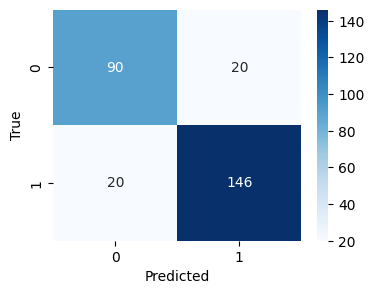

In [106]:
cm = confusion_matrix(df_test.loc[:, 'HeartDisease'], results)

plt.figure(figsize=(4,3))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')

## Task 12: Compute Evaluation Metrics

In [107]:
target_names = ['No Disease', 'Disease']
print(classification_report(df_test.loc[:, 'HeartDisease'], results, target_names=target_names))

              precision    recall  f1-score   support

  No Disease       0.82      0.82      0.82       110
     Disease       0.88      0.88      0.88       166

    accuracy                           0.86       276
   macro avg       0.85      0.85      0.85       276
weighted avg       0.86      0.86      0.86       276



# End